## Linear-Chain CRF in GTN

We show how to implement a simple linear-chain conditional random field (CRF) entirely in GTN.

### Setup

First install GTN if you haven't yet and then import the packages we'll use.

In [136]:
!pip install gtn
import gtn
import numpy as np
from IPython.display import display, Image

### Linear-chain CRF

We'll start by defining some problem dimensions. Each example consists of an input sequence $X = [x_1, \ldots, x_T]$ and a label sequence $Y = [y_1, \ldots, y_T]$ of the same length. The number of inputs (`num_features`) represents the number of symbols each $x_t$ can take. Similarly the number of classes $C$ (in code `num_classes`) is the number of classes for each $y_t$.

We model the conditional log probability of $Y$ given $X$ as:
\begin{equation}
\log p(Y \mid X) = \sum^T_{t=1} f(x_t, y_t) + h(y_t, y_{t-1}) - Z
\end{equation}
where the partition function $Z$ is given by
\begin{equation}
Z = \sum^T_{t=1} \sum_{i=1}^C \sum_{j=1}^{C} f(x_t, i)  + h(i, j).
\end{equation}
The function $f(\cdot)$ gives the so-called unary potentials and the function $h(\cdot)$ gives the transition scores. Note also that in the transition function we let $y_0$ be the start of sequence class `<s>`.

In [139]:
num_features = 3  # number of input features
num_classes = 2   # number of output classes
num_train = 1000  # size of the training set
num_test = 200    # size of the testing set

# Define the input and output symbols used for drawing the graphs:
feature_symbols = {0: 'a', 1: 'b', 2: 'c'}
class_symbols = {0: '0', 1: '1'}

Ok, now we're ready to build, train, and test this model with GTN. Here's a high-level outline of what we need to do:

1. **Generate toy model:** Generate a synthetic, ground-truth model which represents the conditional distribution we aim to recover.
2. **Sample datasets:** Sample a training and test set from this model.
3. **Learn the model:** Learn a randomly initialized model with the training set using stochastic gradient descent.
5. **Evaluate:** Evaluate the learned model on the test set.

### Step 1: Generate a toy model

To generate the model, we only need to construct two graphs: the graph to represent the unary potential function $f(\cdot)$ and the graph to represent the transition function $h(\cdot)$. The code to generate these graphs is below. Let's take a look at what these graphs look like.

In [164]:
def gen_transitions(num_classes, calc_grad=False):
    """Make a bigram transition graph."""
    g = gtn.Graph(calc_grad)
    for i in range(num_classes):
        g.add_node(False, True)
    g.add_node(True, True)
    for i in range(num_classes):
        g.add_arc(num_classes, i, i)  # s(<s>, i)
        for j in range(num_classes):
            g.add_arc(i, j, j)  # s(i, j)
    return g


def gen_potentials(num_features, num_classes, calc_grad=False):
    """Make the unary potential graph"""
    g = gtn.Graph(calc_grad)
    g.add_node(True, True)
    for i in range(num_features):
        for c in range(num_classes):
            g.add_arc(0, 0, i, c)  # f(i, c)
    return g
    
    
def gen_model(num_features, num_classes, calc_grad=False, init=True):
    transitions = gen_transitions(num_classes, calc_grad)
    potentials = gen_potentials(num_features, num_classes, calc_grad)

    # Randomly set the arc weights of the graphs:
    if init:
        transitions.set_weights(
            10 * np.random.randn(transitions.num_arcs()))
        potentials.set_weights(
            10 * np.random.randn(potentials.num_arcs()))
    return potentials, transitions

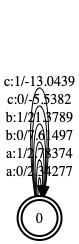

In [165]:
potentials, transitions = gen_model(num_features, num_classes)
gtn.draw(potentials, "potentials.png", feature_symbols, class_symbols)
display(Image("potentials.png"))

The `potentials` graph transduces all possibile input features to all possible class labels and assigns a score for each pair. The graph accomodates arbitrary sequence lengths. The edge label
\begin{equation}
    \xrightarrow{x:y/w}
\end{equation}
means transduce $x$ to $y$ with weight $w$.

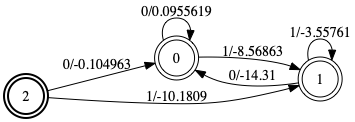

In [166]:
gtn.draw(transitions, "transitions.png", class_symbols)
display(Image("transitions.png"))

The `transitions` graph models the bigram score for each $(i, j)$ pair of class labels. So the transition from state `0` to state `1` models the score of class `1` following class `0`. Similarly the transition from state `2` to state `0` gives the score of class `0` starting at the beginning of $Y$ (i.e. following the start of sequence `<s>`).

### Step 2: Sample the datasets

Next we sample a training and test dataset from the synthetic toy model. The code to sample examples from the model is  below.

In [186]:
def make_chain_graph(seq, calc_grad=False):
    """Make a simple chain graph from an iterable of integers."""
    g = gtn.Graph(calc_grad)
    g.add_node(True)
    for e, s in enumerate(seq):
        g.add_node(False, e + 1 == len(seq))
        g.add_arc(e, e + 1, s)
    return g


def sample_model(
        num_features, num_classes, 
        potentials, transitions,
        num_samples, max_len=20):
    """
    Sample `num_samples` from a linear-chain CRF specified
    by a `potentials` graph and a `transitions` graph. The
    samples will have a random length in `[1, max_len]`.
    """
    model = gtn.compose(potentials, transitions)

    # Draw a random X with length randomly from [1, max_len] and find the
    # most likely Y under the model:
    samples = []
    while len(samples) < num_samples:
        # Sample X:
        T = np.random.randint(1, max_len + 1)
        X = np.random.randint(0, num_features, size=(T,))
        X = make_chain_graph(X)
        # Find the most likely Y given X:
        Y = gtn.viterbi_path(gtn.compose(X, model))
        # Clean up Y:
        Y = gtn.project_output(Y)
        Y.set_weights(np.zeros(Y.num_arcs()))
        samples.append((X, Y))
    return samples

Let's break this down into a few steps. 

- We construct the full model by composing the `potentials` graph and the `transitions` graph. We can get the score for any $(X, Y)$ pair by following it's path in this graph. We view the composition below. The model looks a bit hairy but really just gives a score for any $(X, Y)$ according to $f(\cdot)$ and $h(\cdot)$.

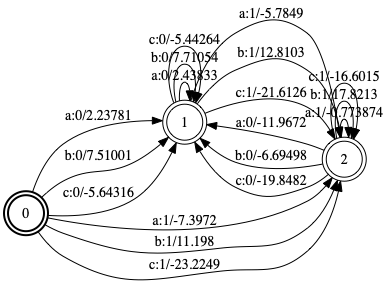

In [168]:
model = gtn.compose(potentials, transitions)
gtn.draw(model, "model.png", feature_symbols, class_symbols)
display(Image("model.png"))

- The next step is to sample a random $X$ with a random length and convert it into a GTN graph. We draw a random input of length $5$ below.

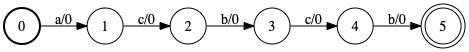

In [169]:
X = make_chain_graph(np.random.randint(0, num_features, size=(5,)))
gtn.draw(X, "X.png", feature_symbols)
display(Image("X.png"))

- Next, we find the most likely $Y$ for the given $X$ according to the model. We first constrain the model to only allow paths with inputs given by $X$ (with `gtn.compose(X, model)`).

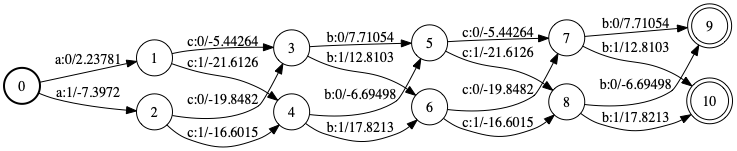

In [172]:
constrained = gtn.compose(X, gtn.compose(potentials, transitions))
gtn.draw(constrained, "constrained.png", feature_symbols, class_symbols)
display(Image("constrained.png"))

- We compute $Y$ by finding the most likely path in this constrained model with `gtn.viterbi_path`. We clean $Y$ up by removing the input features and clearing the weights from the graph. Then we save the sample to our dataset.

We can now use `sample_model` to sample our training and test datasets:

In [184]:
# Sample training and test datasets:
samples = sample_model(
    num_features, num_classes, potentials, transitions, num_train + num_test)
train, test = samples[:num_train], samples[num_train:]

### Step 3: Learn the model

We proceed to learn the parameters of a randomly initialized model using the training dataset. We use a simple SGD optimization procedure. The first step is to define the loss function following the equation we gave earlier for $\log P(Y\mid X)$.

In [174]:
def crf_loss(X, Y, potentials, transitions):
    feature_graph = gtn.compose(X, potentials)
    
    # Compute the unnormalized score of `(X, Y)`
    target_graph = gtn.compose(feature_graph, gtn.intersect(Y, transitions))
    target_score = gtn.forward_score(target_graph)
        
    # Compute the partition function
    norm_graph = gtn.compose(feature_graph, transitions)
    norm_score = gtn.forward_score(norm_graph)
        
    return gtn.subtract(norm_score, target_score)

The next bit is a standard SGD loop, which computes the loss for an example, then computes the gradients of the loss with respect to the model parameters and takes a gradient step.

In [175]:
def update_params(learning_rate, *graphs):
    """Take a gradient step on each graph in `graphs`."""
    for graph in graphs:
        params = graph.weights_to_numpy()
        grad = graph.grad().weights_to_numpy()
        params += learning_rate * grad
        graph.set_weights(params)
        
        
def sampler(dataset):
    """Iterator which randomly samples from a dataset."""
    while True:
        indices = np.random.permutation(len(dataset))
        for idx in indices:
            yield dataset[idx]
            
# Make the graphs to be learned:
potentials, transitions = gen_model(
    num_features, num_classes, calc_grad=True, init=False)

# Run the SGD loop:
learning_rate = 1e-2
max_iter = 10000
losses = []
for it, (X, Y) in enumerate(sampler(train)):
    # Compute the loss and take a gradient step:
    loss = crf_loss(X, Y, potentials, transitions)
    gtn.backward(loss)
    update_params(-learning_rate, potentials, transitions)

    # Clear the gradients:
    transitions.zero_grad()
    potentials.zero_grad()

    losses.append(loss.item())
    if (it + 1) % 1000 == 0:
        print("=" * 50)
        print(f"Iteration {it + 1}, Avg. Loss {np.mean(losses):.3f}")
        losses = []
    if it == max_iter:
        break

Iteration 1000, Avg. Loss 1.368
Iteration 2000, Avg. Loss 0.647
Iteration 3000, Avg. Loss 0.506
Iteration 4000, Avg. Loss 0.433
Iteration 5000, Avg. Loss 0.389
Iteration 6000, Avg. Loss 0.354
Iteration 7000, Avg. Loss 0.328
Iteration 8000, Avg. Loss 0.308
Iteration 9000, Avg. Loss 0.292
Iteration 10000, Avg. Loss 0.279


### Step 4: Evaluate

The last step is to evaluate the learned model's accuracy on the test set.

In [183]:
correct = 0.0
total = 0
for X, Y in test:
    full_graph = gtn.compose(gtn.compose(X, potentials), transitions)
    prediction = gtn.viterbi_path(full_graph).labels_to_list(False)
    correct += np.sum(np.array(Y.labels_to_list()) == prediction)
    total += len(prediction)
print("Test: Accuracy {:.3f}".format(correct / total))

Test: Accuracy 0.997
